In [1]:
!pip install kaggle

In [2]:
# Set your own project id here
PROJECT_ID = 'myprojectlearn-bqml'

from google.cloud import bigquery
client = bigquery.Client(project = PROJECT_ID)
dataset = client.create_dataset('bqml_tutorial', exists_ok=True)

from google.cloud.bigquery import magics
#from kaggle.gcp import KaggleKernelCredentials
#magics.context.credentials = KaggleKernelCredentials()
magics.context.project = PROJECT_ID

In [3]:
# create a reference to our table
table = client.get_table("bigquery-public-data.google_analytics_sample.ga_sessions_*")

# look at five rows from our dataset
client.list_rows(table, max_results=5).to_dataframe()

,visitorId,visitNumber,visitId,visitStartTime,date,totals,trafficSource,device,geoNetwork,customDimensions,hits,fullVisitorId,userId,clientId,channelGrouping,socialEngagementType
0,NaN,1,1501583974,1501583974,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Car...",[],"[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut...",2248281639583218707,None,None,Organic Search,Not Socially Engaged
1,NaN,1,1501616585,1501616585,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 12, 'minu...",8647436381089107732,None,None,Organic Search,Not Socially Engaged
2,NaN,1,1501583344,1501583344,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Asia', 'subContinent': 'Souther...","[{'index': 4, 'value': 'APAC'}]","[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut...",2055839700856389632,None,None,Organic Search,Not Socially Engaged
3,NaN,1,1501573386,1501573386,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Europe', 'subContinent': 'Weste...","[{'index': 4, 'value': 'EMEA'}]","[{'hitNumber': 1, 'time': 0, 'hour': 0, 'minut...",0750846065342433129,None,None,Direct,Not Socially Engaged
4,NaN,8,1501651467,1501651467,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 22, 'minu...",0573427169410921198,None,None,Organic Search,Not Socially Engaged


In [4]:
# create a small sample dataframe
sample_table = client.list_rows(table, max_results=5).to_dataframe()

# get the first cell in the "totals" column
sample_table.totals[0]

{'visits': 1,
 'hits': 1,
 'pageviews': 1,
 'timeOnSite': None,
 'bounces': 1,
 'transactions': None,
 'transactionRevenue': None,
 'newVisits': 1.0,
 'screenviews': None,
 'uniqueScreenviews': None,
 'timeOnScreen': None,
 'totalTransactionRevenue': None,
 'sessionQualityDim': 1}

In [5]:
%load_ext google.cloud.bigquery

In [6]:
# Create model

In [7]:
%%bigquery
CREATE MODEL IF NOT EXISTS `bqml_tutorial.sample_model`
OPTIONS(model_type='logistic_reg') AS
SELECT
  IF(totals.transactions IS NULL, 0, 1) AS label,
  IFNULL(device.operatingSystem, "") AS os,
  device.isMobile AS is_mobile,
  IFNULL(geoNetwork.country, "") AS country,
  IFNULL(totals.pageviews, 0) AS pageviews
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
  _TABLE_SUFFIX BETWEEN '20160801' AND '20170630'

Query complete after 0.01s: 100%|██████████| 1/1 [00:00<00:00, 1003.42query/s]


""


In [8]:
#Getting Statistics

In [9]:
%%bigquery
SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `bqml_tutorial.sample_model`)
ORDER BY iteration 

Downloading: 100%|██████████| 9/9 [00:01<00:00,  5.49rows/s]


,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,0,0.521573,0.521380,0.2,9261
1,0,1,0.320692,0.320174,0.4,12256
2,0,2,0.169802,0.168849,0.8,11999
3,0,3,0.097545,0.096203,1.6,10750
4,0,4,0.067776,0.066406,3.2,11357
5,0,5,0.053888,0.053337,6.4,12300
6,0,6,0.047345,0.048273,12.8,12463
7,0,7,0.044654,0.045499,25.6,12008
8,0,8,0.043878,0.045445,25.6,18721


In [10]:
# Evaluate model

In [11]:
%%bigquery
SELECT
  *
FROM ML.EVALUATE(MODEL `bqml_tutorial.sample_model`, (
  SELECT
    IF(totals.transactions IS NULL, 0, 1) AS label,
    IFNULL(device.operatingSystem, "") AS os,
    device.isMobile AS is_mobile,
    IFNULL(geoNetwork.country, "") AS country,
    IFNULL(totals.pageviews, 0) AS pageviews
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
    _TABLE_SUFFIX BETWEEN '20170701' AND '20170801'))

Downloading: 100%|██████████| 1/1 [00:01<00:00,  1.97s/rows]


,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.468504,0.110801,0.985343,0.179217,0.046242,0.981731


In [12]:
%%bigquery roc
SELECT
  *
FROM
  ML.ROC_CURVE(MODEL `bqml_tutorial.sample_model`)



Downloading: 100%|██████████| 90/90 [00:01<00:00, 64.95rows/s]


In [13]:
# check out the data that was returned...
roc.head()



,threshold,recall,false_positive_rate,true_positives,false_positives,true_negatives,false_negatives
0,1.000000,0.008197,0.000000,1,0,9992,121
1,0.252477,0.319672,0.006605,39,66,9926,83
2,0.104013,0.540984,0.013811,66,138,9854,56
3,0.059840,0.696721,0.022718,85,227,9765,37
4,0.044843,0.819672,0.030825,100,308,9684,22


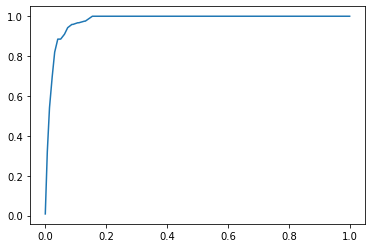

In [14]:
# and plot our ROC curve!
import matplotlib.pyplot as plt

# plot the false positive rate by true postive rate (aka recall)
plt.plot(roc.false_positive_rate, roc.recall)



In [15]:
%%bigquery 
SELECT
  *
FROM
  ML.confusion_matrix(MODEL `bqml_tutorial.sample_model`)

Downloading: 100%|██████████| 2/2 [00:01<00:00,  1.33rows/s]


,expected_label,_0,_1
0,0,9957,35
1,1,100,22


In [16]:
# Using the model

In [17]:
%%bigquery
SELECT
  country,
  SUM(predicted_label) as total_predicted_purchases
FROM ML.PREDICT(MODEL `bqml_tutorial.sample_model`, (
  SELECT
    IFNULL(device.operatingSystem, "") AS os,
    device.isMobile AS is_mobile,
    IFNULL(totals.pageviews, 0) AS pageviews,
    IFNULL(geoNetwork.country, "") AS country
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
    _TABLE_SUFFIX BETWEEN '20170701' AND '20170801'))
  GROUP BY country
  ORDER BY total_predicted_purchases DESC
  LIMIT 10

Downloading: 100%|██████████| 10/10 [00:01<00:00,  7.20rows/s]


,country,total_predicted_purchases
0,United States,220
1,Taiwan,8
2,Canada,7
3,India,2
4,Japan,2
5,Turkey,2
6,United Kingdom,1
7,Guyana,1
8,Brazil,1
9,Serbia,1


In [18]:
%%bigquery
SELECT
  fullVisitorId,
  SUM(predicted_label) as total_predicted_purchases
FROM ML.PREDICT(MODEL `bqml_tutorial.sample_model`, (
  SELECT
    IFNULL(device.operatingSystem, "") AS os,
    device.isMobile AS is_mobile,
    IFNULL(totals.pageviews, 0) AS pageviews,
    IFNULL(geoNetwork.country, "") AS country,
    fullVisitorId
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
    _TABLE_SUFFIX BETWEEN '20170701' AND '20170801'))
  GROUP BY fullVisitorId
  ORDER BY total_predicted_purchases DESC
  LIMIT 10

Downloading: 100%|██████████| 10/10 [00:01<00:00,  7.11rows/s]


,fullVisitorId,total_predicted_purchases
0,9417857471295131045,4
1,2158257269735455737,2
2,489038402765684003,2
3,2969418676126258798,2
4,5073919761051630191,2
5,8388931032955052746,2
6,112288330928895942,2
7,2105122376016897629,2
8,7420300501523012460,2
9,0456807427403774085,2


In [19]:
%%bigquery
SELECT
 *
FROM ML.PREDICT(MODEL `bqml_tutorial.sample_model`, (
  SELECT
    IFNULL(device.operatingSystem, "") AS os,
    device.isMobile AS is_mobile,
    IFNULL(totals.pageviews, 0) AS pageviews,
    IFNULL(geoNetwork.country, "") AS country,
    fullVisitorId
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
    _TABLE_SUFFIX BETWEEN '20170701' AND '20170801'))
  LIMIT 100

Downloading: 100%|██████████| 100/100 [00:01<00:00, 66.51rows/s]


,predicted_label,predicted_label_probs,os,is_mobile,pageviews,country,fullVisitorId
0,0,"[{'label': 1, 'prob': 0.0029177879214465794}, ...",Windows,False,1,United Kingdom,3314061401814753513
1,0,"[{'label': 1, 'prob': 0.0027748799555421637}, ...",Windows,False,1,Italy,7260770260790282162
2,0,"[{'label': 1, 'prob': 0.002874123424966384}, {...",Windows,False,1,Brazil,155925421497788059
3,0,"[{'label': 1, 'prob': 0.0028849707665170774}, ...",Windows,False,1,India,4122481841454463388
4,0,"[{'label': 1, 'prob': 0.0029549670266552017}, ...",Windows,False,1,Ukraine,9682778111588626139
...,...,...,...,...,...,...,...
95,0,"[{'label': 1, 'prob': 0.004877769702412528}, {...",Macintosh,False,1,Japan,1610238037007759121
96,0,"[{'label': 1, 'prob': 0.002552861020043088}, {...",Windows,False,1,Singapore,8869405394836093411
97,0,"[{'label': 1, 'prob': 0.002819007196235452}, {...",Windows,False,1,Colombia,4414247141148257957
98,0,"[{'label': 1, 'prob': 0.0028445866862490438}, ...",Windows,False,1,Peru,4837032438823565843


In [20]:
%%bigquery
WITH consult as
(SELECT
 *
FROM ML.PREDICT(MODEL `bqml_tutorial.sample_model`, (
  SELECT
    IFNULL(device.operatingSystem, "") AS os,
    device.isMobile AS is_mobile,
    IFNULL(totals.pageviews, 0) AS pageviews,
    IFNULL(geoNetwork.country, "") AS country,
    fullVisitorId
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
  WHERE
    _TABLE_SUFFIX BETWEEN '20170701' AND '20170801'))
  LIMIT 100)

SELECT os,
is_mobile,
pageviews,
country,
fullVisitorId,
predicted_label_probs,
(SELECT prob
 FROM UNNEST(predicted_label_probs) where label = 1) as prob1 

FROM consult

  LIMIT 10;

Downloading: 100%|██████████| 10/10 [00:01<00:00,  7.82rows/s]


,os,is_mobile,pageviews,country,fullVisitorId,predicted_label_probs,prob1
0,Android,True,1,Netherlands,4576978993060509058,"[{'label': 1, 'prob': 0.0018379431103867677}, ...",0.001838
1,Windows,False,1,Thailand,0686272241135131743,"[{'label': 1, 'prob': 0.002854690573998185}, {...",0.002855
2,Windows,False,1,Netherlands,5769691250560076510,"[{'label': 1, 'prob': 0.0028008728782548996}, ...",0.002801
3,Windows,False,1,Malaysia,2341709029923823417,"[{'label': 1, 'prob': 0.002834147286855323}, {...",0.002834
4,Android,True,1,United States,0851060264696052177,"[{'label': 1, 'prob': 0.005216050541134701}, {...",0.005216
5,Windows,False,1,United States,3234372262766870369,"[{'label': 1, 'prob': 0.007934759276447642}, {...",0.007935
6,Windows,False,1,Hong Kong,6132471333501698168,"[{'label': 1, 'prob': 0.0024469195489504408}, ...",0.002447
7,Macintosh,False,1,Uruguay,8606852295878856433,"[{'label': 1, 'prob': 0.004952414731624589}, {...",0.004952
8,Macintosh,False,1,Czechia,1630954625564802779,"[{'label': 1, 'prob': 0.005332699806409172}, {...",0.005333
9,Windows,False,1,Brazil,171096195049349654,"[{'label': 1, 'prob': 0.002874123424966384}, {...",0.002874
